Tarea 1 DAML Alejandro Martel

Instrucciones

Su notebook con las respuestas a la tarea se deben entregar a mas tardar el dia 24/04/25 hasta las 21:00, subiendolo al repositorio en la carpeta tareas/2025.

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. La data a utilizar es machine_failure_data.csv.

Las variables tienen la siguiente descripcion:

Date: data medida en frecuencia diaria.  
Location: ubicacion del medidor.  
Min_Temp: temperatura minima observada.  
Max_Temp: temperatura maxima observada.  
Leakage: Filtracion medida en el area.  
Evaporation: Tasa de evaporacion.  
Electricity: Consumo electrico KW.  
Parameter#: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes.  
Failure today: El sensor reporta fallo (o no).

### 1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

__R.__ Importamos las librerias y procedemos con el analisis de las variables.

In [2]:
df = pd.read_csv("../../data/machine_failure_data.csv", delimiter=",", decimal='.')
df= df.dropna(subset=["Failure_today"])
df.head()

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,...,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter6_9am,Parameter6_3pm,Parameter7_9am,Parameter7_3pm,Failure_today
0,12/1/2008,3,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,12/2/2008,3,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,12/3/2008,3,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,12/4/2008,3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,12/5/2008,3,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No


Se observan una gran cantidad de datos nulos en las variables Evaporation, Electricity y del parametro 6

In [3]:
print(df.isnull().sum())

Date                    0
Location                0
Min_Temp              468
Max_Temp              307
Leakage                 0
Evaporation         59694
Electricity         66805
Parameter1_Dir       9163
Parameter1_Speed     9105
Parameter2_9am       9660
Parameter2_3pm       3670
Parameter3_9am       1055
Parameter3_3pm       2531
Parameter4_9am       1517
Parameter4_3pm       3501
Parameter5_9am      13743
Parameter5_3pm      13769
Parameter6_9am      52625
Parameter6_3pm      56094
Parameter7_9am        656
Parameter7_3pm       2624
Failure_today           0
dtype: int64


Para la limpieza:  
1. Se transforman las variables con direccion a sus componentes seno y coseno.   
2. tambien se cambia el valor "No" y "Yes" de la variable Failure_today por 0 y 1.   
3. en al variable leakage agrupamos en 2 grupos, 0 si no hay leak y 1 si existe leak.   
4. inputamos valores de la mediana en electricity y evaporation.  
5. finalmente se quita los outliders fuera del percentil 99.  

In [4]:
direccion_map = {
    'N': 0, 'NNE': 1, 'NE': 2, 'ENE': 3,
    'E': 4, 'ESE': 5, 'SE': 6, 'SSE': 7,
    'S': 8, 'SSW': 9, 'SW': 10, 'WSW': 11,
    'W': 12, 'WNW': 13, 'NW': 14, 'NNW': 15}

df['Parameter1_Dir'] = df['Parameter1_Dir'].map(direccion_map)
df['Parameter2_9am'] = df['Parameter2_9am'].map(direccion_map)
df['Parameter2_3pm'] = df['Parameter2_3pm'].map(direccion_map)

# Convertimos los valores a ángulos en radianes
def circular_features(x):
    radians = x * (2 * np.pi / 16)  # 16 direcciones
    return np.sin(radians), np.cos(radians)

# Aplicar la función a cada columna
df['Param1_Dir_sin'], df['Param1_Dir_cos'] = zip(*df['Parameter1_Dir'].apply(circular_features))
df['Param2_9am_sin'], df['Param2_9am_cos'] = zip(*df['Parameter2_9am'].apply(circular_features))
df['Param2_3pm_sin'], df['Param2_3pm_cos'] = zip(*df['Parameter2_3pm'].apply(circular_features))
df=df.drop(columns=["Parameter1_Dir","Parameter2_9am","Parameter2_3pm"])

failure_map = {"No":0,"Yes":1}

df['Failure_today'] = df['Failure_today'].map(failure_map)
df.describe()

df["Leakage"] = df["Leakage"].apply(lambda x: 1 if x != 0 else 0)

median_value = df["Electricity"].median()
df["Electricity"].fillna(median_value, inplace=True)

median_value = df["Evaporation"].median()
df["Evaporation"].fillna(median_value, inplace=True)

for column in df.columns[1:]:
    var = df[column].quantile(0.99)
    df=df[df[column]<=var]

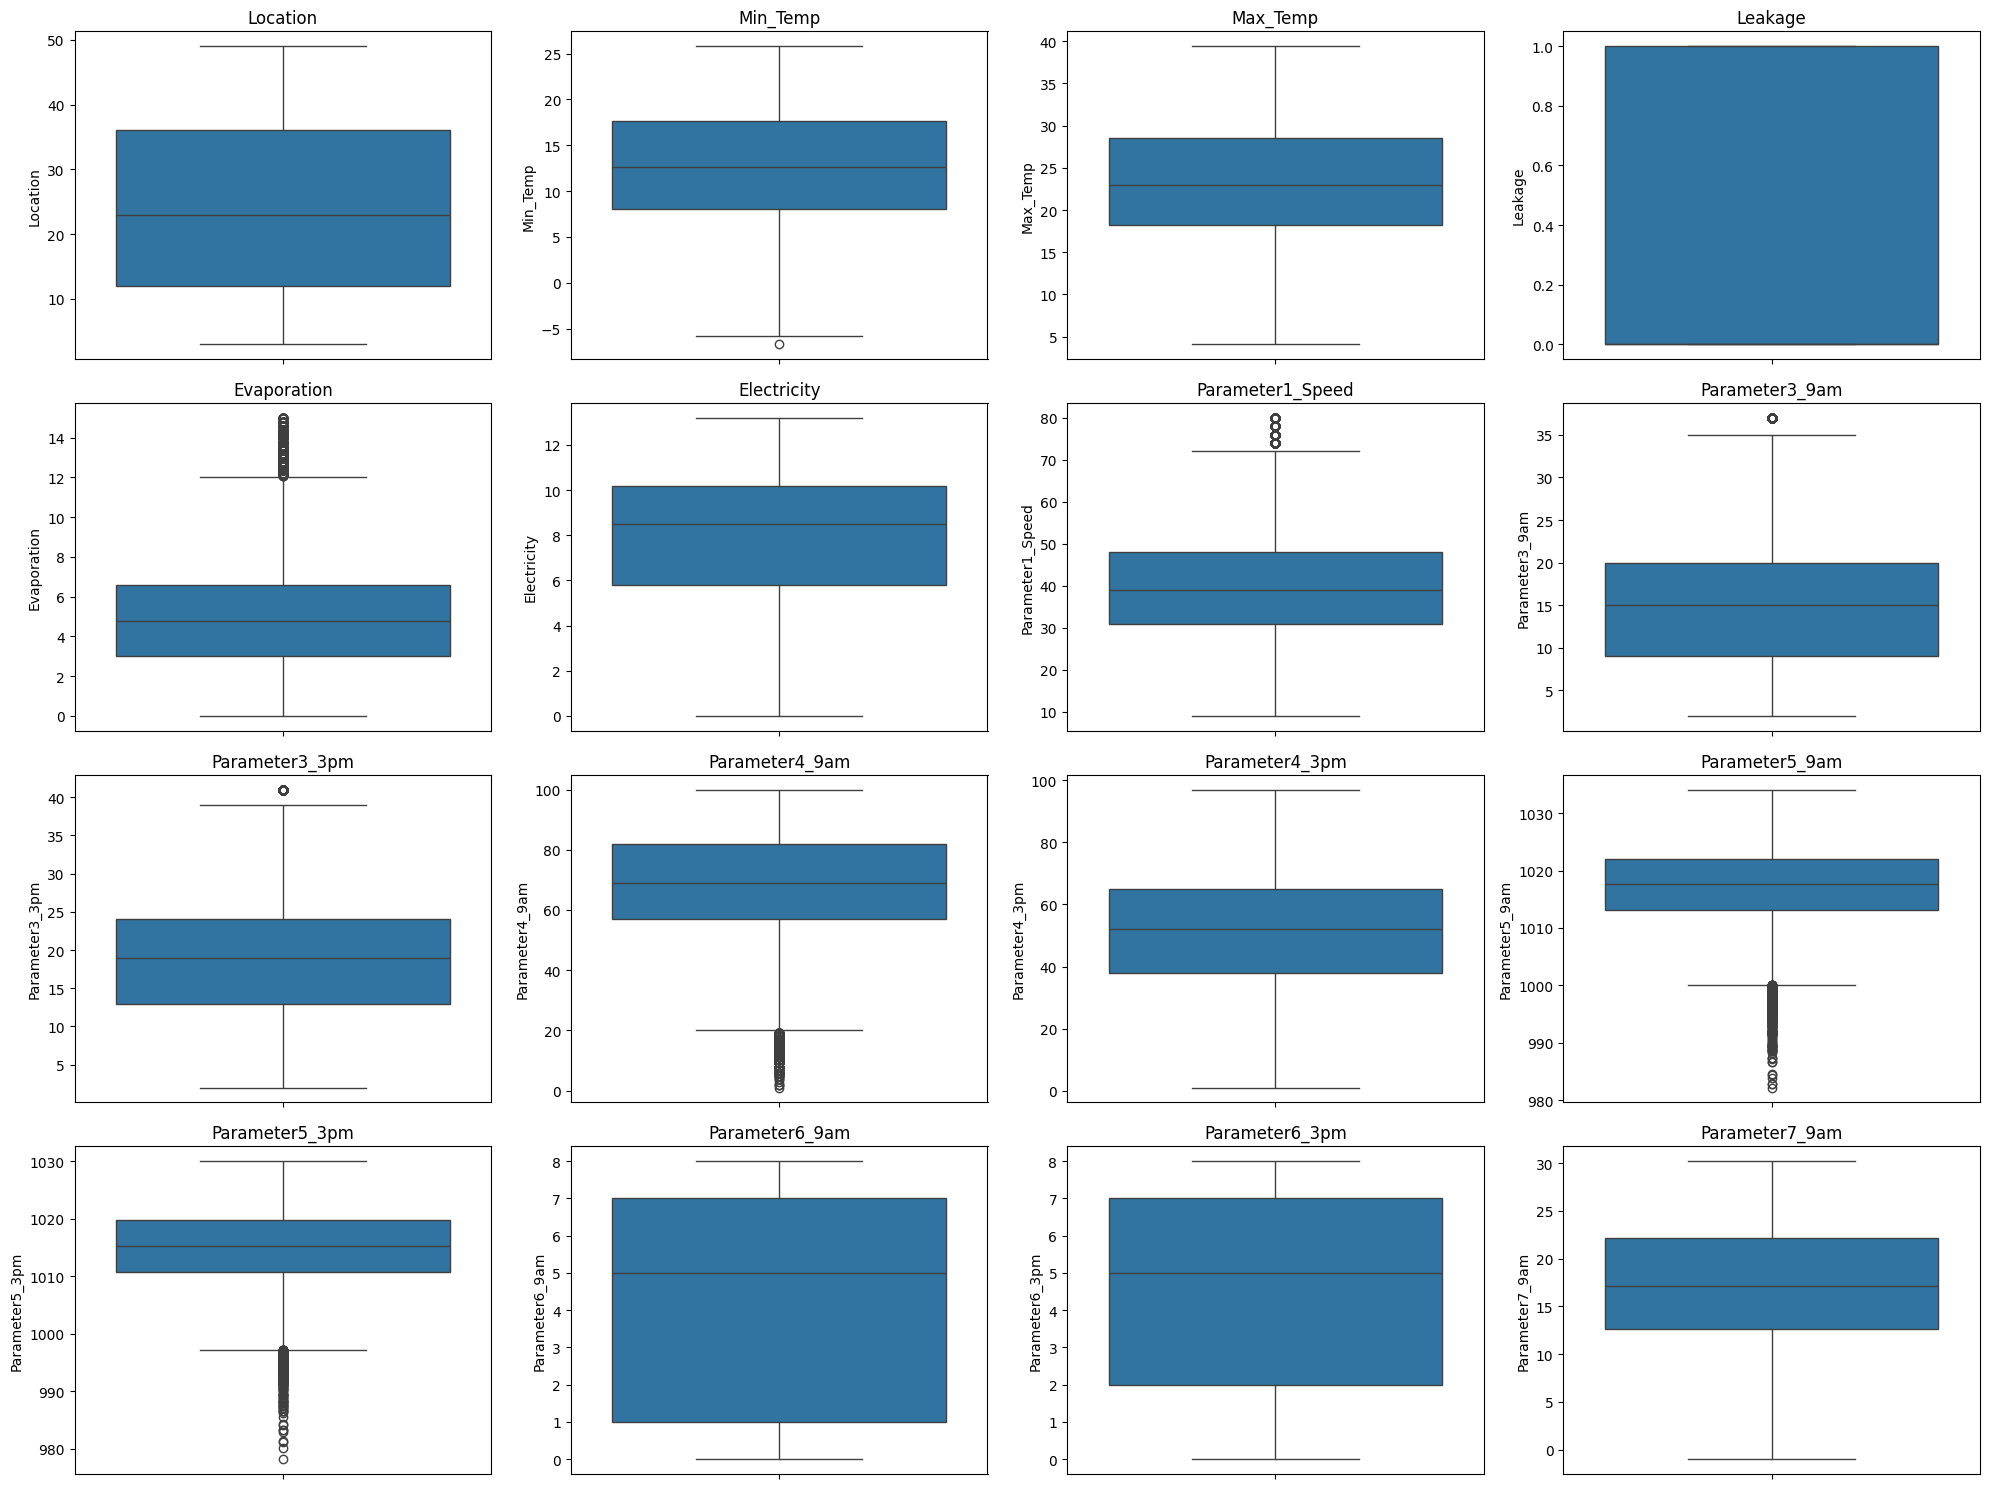

In [5]:
# Crear boxplots para cada columna
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns[1:], 1):
    if i <= 16: # Asegurarse de que el número de subplots no exceda 16
        plt.subplot(4, 4, i)
        sns.boxplot(y=df[column])
        plt.title(column)

plt.tight_layout()
plt.show()

Procedemos a ver la correlacion entre variables en un grafico.

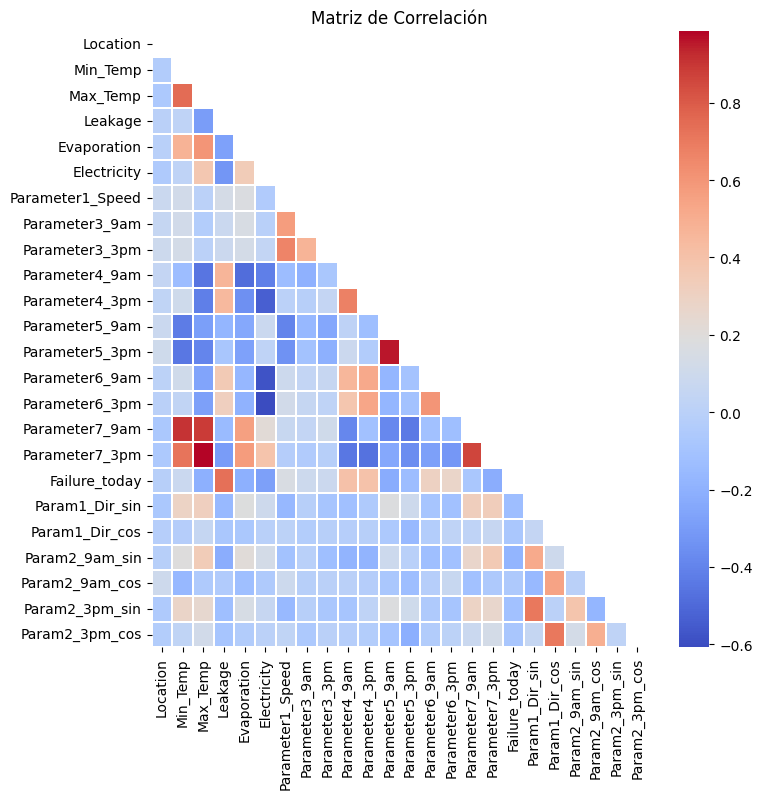

In [6]:
M_corr = df.drop(columns=["Date"]).corr()
mask = np.triu(np.ones_like(M_corr, dtype=bool))
plt.figure(figsize=(8, 8))
sns.heatmap(M_corr, cmap='coolwarm', linewidths=0.2, mask=mask)
plt.title('Matriz de Correlación')
plt.show()

Debido a la correlación existente entre la variable 7 y las temperaturas, se tomó la decisión de eliminar dicha variable. Del mismo modo, considerando la alta cantidad de datos nulos presentes en la variable 6, esta también fue descartada. En consecuencia, se optó por emplear únicamente la variable max_temp, dada la relación observada entre ambas temperaturas. Asimismo, se seleccionó la variable Parameter5_3pm, debido a su significativa correlación con el mismo parámetro registrado a las 9 a.m.


In [7]:
df_limpio=df.drop(columns=["Min_Temp","Parameter6_9am","Parameter6_3pm","Parameter7_9am","Parameter7_3pm","Parameter5_3pm"])
df_limpio.head()
df_limpio.dropna(inplace=True)

Luego de la limpieza de variables, la matriz de correlacion queda de la siguiente manera.

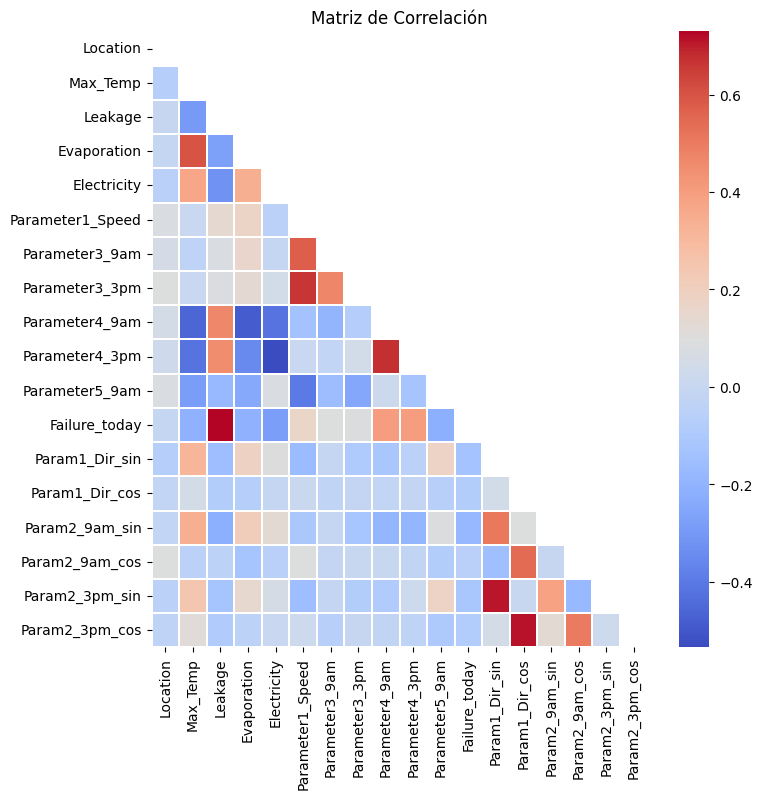

In [8]:
M_corr = df_limpio.drop(columns=["Date"]).corr()
mask = np.triu(np.ones_like(M_corr, dtype=bool))
plt.figure(figsize=(8, 8))
sns.heatmap(M_corr, cmap='coolwarm', linewidths=0.2, mask=mask)
plt.title('Matriz de Correlación')
plt.show()

Y las variables así.

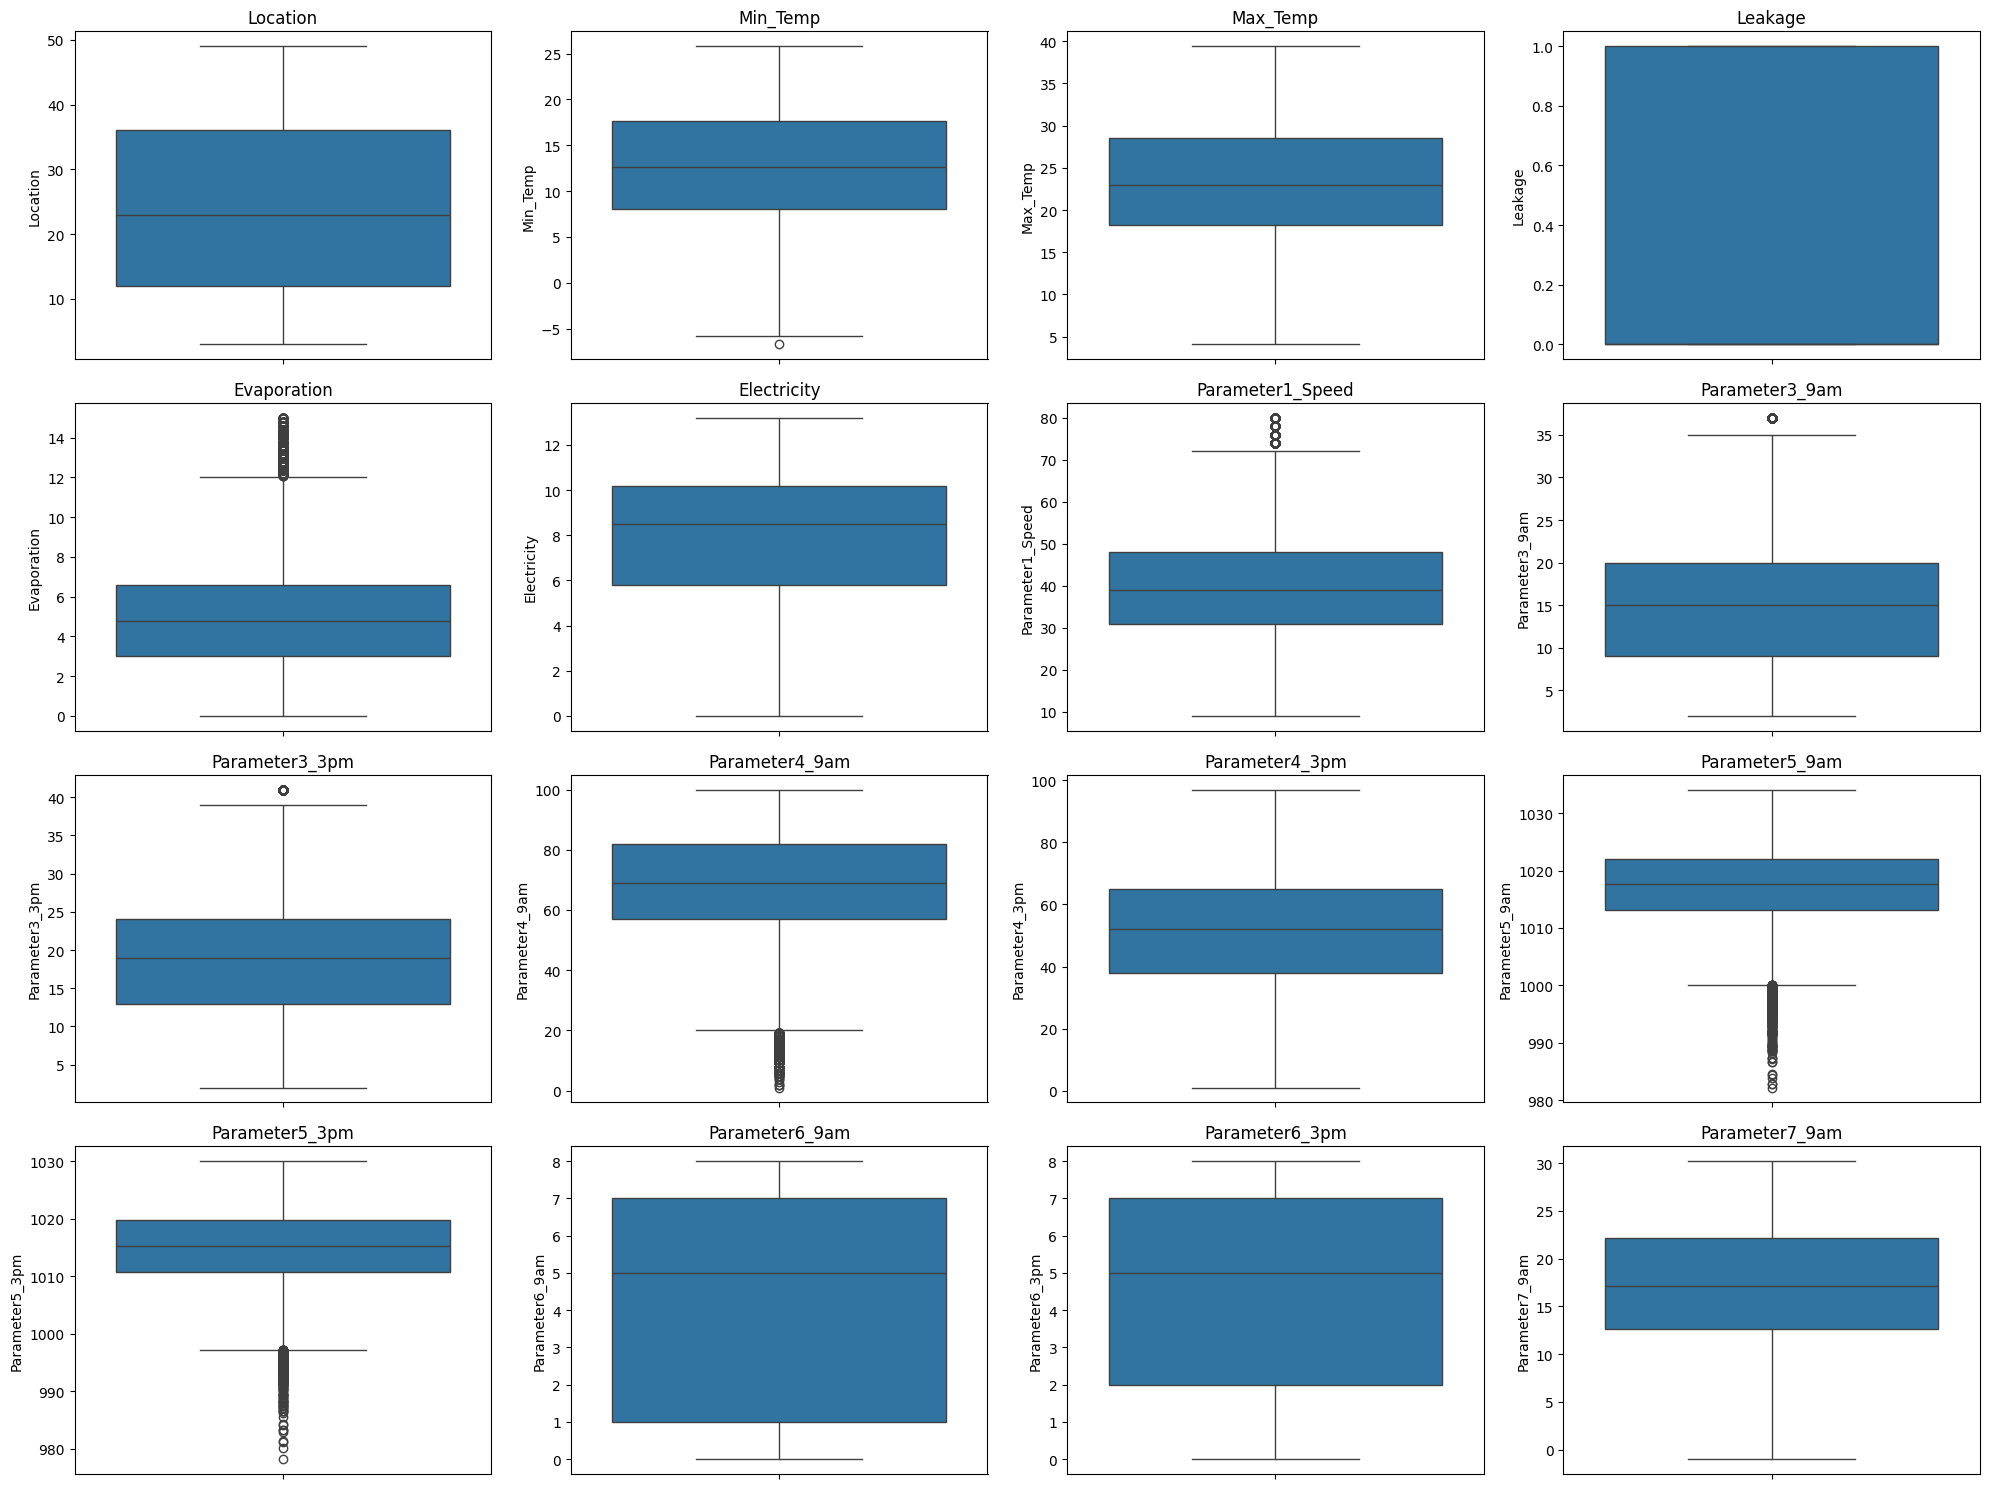

In [9]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns[1:], 1):
    if i <= 16: # Asegurarse de que el número de subplots no exceda 16
        plt.subplot(4, 4, i)
        sns.boxplot(y=df[column])
        plt.title(column)

plt.tight_layout()
plt.show()

### 2. Ejecute un modelo de probabilidad lineal (MCO) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [10]:
mod = smf.ols(formula="Failure_today ~ Max_Temp + Leakage + Electricity + Parameter1_Speed + Parameter3_9am + Param1_Dir_sin + Param1_Dir_cos + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am +  + Param2_3pm_cos + Param2_3pm_sin + Param2_9am_cos + Param2_9am_sin", data=df_limpio)
print(f"modelo:","Failure_today ~ Max_Temp + Leakage + Electricity + Parameter1_Speed + Parameter3_9am + Param1_Dir_sin + Param1_Dir_cos + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am +  + Param2_3pm_cos + Param2_3pm_sin + Param2_9am_cos + Param2_9am_sin")
res = mod.fit()
print(res.summary())

modelo: Failure_today ~ Max_Temp + Leakage + Electricity + Parameter1_Speed + Parameter3_9am + Param1_Dir_sin + Param1_Dir_cos + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am +  + Param2_3pm_cos + Param2_3pm_sin + Param2_9am_cos + Param2_9am_sin
                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     5209.
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:19:42   Log-Likelihood:                -10838.
No. Observations:               62743   AIC:                         2.171e+04
Df Residuals:                   62727   BIC:                         2.185e+04
Df Model:                          15                                         
Covariance Type:       

__R.__ A partir del modelo podemos observar un $R^2$ de 0.55 lo cual es un valor bueno un 55% de las fallas se explican por los predictores, asi mismo todas las variables son significativas, menos el parametro1_direccion, las variables que se pueden destacar son leakage, que explica que si existen fugas aumentan en un 57% las posibilidades de fallas, también se puede señalar electricity, indica que a mayor valor, existen menos fallas en un 0.13%.

### 3. Ejecute un modelo probit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [11]:
# Definir el modelo Probit en lugar de OLS
mod_probit = smf.probit(formula="Failure_today ~ Max_Temp + Leakage + Electricity + Parameter1_Speed + Parameter3_9am + Param1_Dir_sin + Param1_Dir_cos + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am +  + Param2_3pm_cos + Param2_3pm_sin + Param2_9am_cos + Param2_9am_sin", data=df_limpio)

# Ajustar el modelo
res_probit = mod_probit.fit()

# Mostrar resultados
print(res_probit.summary())


         Current function value: 0.223342
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:                62743
Model:                         Probit   Df Residuals:                    62727
Method:                           MLE   Df Model:                           15
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.6001
Time:                        19:19:44   Log-Likelihood:                -14013.
converged:                      False   LL-Null:                       -35038.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           23.2717      2.761      8.430      0.000      17.861      28.683
Max_Temp             0.0158      0.002      8.6

Volvemos a correr el modelo quitando las variables no significativas(electricity, Param1_Dir_sin, Leakage).

In [12]:

# Definir el modelo Probit en lugar de OLS
mod_probit = smf.probit(formula="Failure_today ~ Max_Temp + Parameter1_Speed + Parameter3_9am + Param1_Dir_cos + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am +  + Param2_3pm_cos + Param2_3pm_sin + Param2_9am_cos + Param2_9am_sin", data=df_limpio)

# Ajustar el modelo
res_probit = mod_probit.fit()

# Mostrar resultados
print(res_probit.summary())


Optimization terminated successfully.
         Current function value: 0.398450
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:                62743
Model:                         Probit   Df Residuals:                    62730
Method:                           MLE   Df Model:                           12
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2865
Time:                        19:19:44   Log-Likelihood:                -25000.
converged:                       True   LL-Null:                       -35038.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           37.4767      1.244     30.122      0.000      35.038      39.915
Max_Temp   

__R.__ En este modelo, quitando las variables no significativas nos da un pseudo $R^2$  del 0.28, lo cual es aceptable(<0.2), asi mismo el modelo converge lo cual indica que el modelo ha estimado correctamente y es estable. En los coeficientes podemos destacar los parametros seno y coseno del Param2_3pm, los cuales indican, transformandolos a Direccion nuevamente, que si el viento viene del sur-suroeste hay menos probabilidad de falla. Otra variable a considerar es param1_speed, la cual dice que un aumento en la velocidad de 1 unidad aumenta la probabilidad de fallo.


In [13]:
#calcular direccion
import numpy as np

# Coeficientes de las variables
param2_3pm_cos = -4.0716
param2_3pm_sin = -0.0323

# Calcular el ángulo en radianes
angulo_radianes = np.arctan2(param2_3pm_sin, param2_3pm_cos)

# Convertir a grados
angulo_grados = np.degrees(angulo_radianes)

# Normalizar el ángulo para que esté entre 0 y 360 grados
if angulo_grados < 0:
    angulo_grados += 360

# Definir las 16 direcciones
direcciones = [
    "Norte", "Norte-Noreste", "Noreste", "Este-Noreste", 
    "Este", "Este-Sureste", "Sureste", "Sur-Sureste", 
    "Sur", "Sur-Suroeste", "Suroeste", "Oeste-Suroeste", 
    "Oeste", "Oeste-Noroeste", "Noroeste", "Norte-Noroeste"
]

# Calcular el índice de la dirección más cercana (22.5° por dirección)
indice_direccion = int((angulo_grados + 11.25) // 22.5)  # El +11.25 ayuda a redondear hacia la dirección correcta

# Obtener la dirección cardinal correspondiente
direccion = direcciones[indice_direccion]

print(f"Ángulo en grados: {angulo_grados}")
print(f"Dirección cardinal hacia la que apunta el vector: {direccion}")

Ángulo en grados: 180.45451784499076
Dirección cardinal hacia la que apunta el vector: Sur


### 4. Ejecute un modelo logit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [14]:
mod_logit = smf.logit(formula="Failure_today ~Max_Temp + Parameter1_Speed + Parameter3_9am + Param1_Dir_cos + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am +  + Param2_3pm_cos + Param2_3pm_sin + Param2_9am_cos + Param2_9am_sin ", data=df_limpio)
# Ajustar el modelo
res_logit = mod_logit.fit()
# Mostrar resultados
print(res_logit.summary())


Optimization terminated successfully.
         Current function value: 0.398474
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:                62743
Model:                          Logit   Df Residuals:                    62730
Method:                           MLE   Df Model:                           12
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2864
Time:                        19:19:45   Log-Likelihood:                -25001.
converged:                       True   LL-Null:                       -35038.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           64.6411      2.171     29.774      0.000      60.386      68.896
Max_Temp   

__R.__ En este modelo en general los parametro tienden a tener mayor magnitud que en el probit.

### 5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

__R.__ Las diferencias fueron distintos $R^2$ y coeficientes de las variables, los resultados varian por la naturaleza de los modelos, en el MCO la variable dependiente es considerada continua, en cambio probit y logit lo consideran binaria(como es en este trabajo). El modelo más adecuado a mi parecer es el logit, ya que considera una funcion logistica, que permite mayor robustez, tambien por presentarse una variable dependiente binaria y además porque convergio. Las variables mas robustas fueron: Max_Temp,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Componentes trigonométricos de la dirección del viento (Param2_9am_cos, Param2_9am_sin, etc.)

### 6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [15]:
#Agrupacion datos
df_limpio["Date"] = pd.to_datetime(df_limpio["Date"])
df_limpio["Mes_Año"] = df_limpio["Date"].dt.to_period("M")
df_mensual = df_limpio.groupby("Mes_Año").mean(numeric_only=True)
fallas_mensual = df_limpio.groupby("Mes_Año")["Failure_today"].sum()
df_agrupado = df_mensual.copy()
df_agrupado["fallas_mensual"]= fallas_mensual
df_agrupado.head(14000)

,Location,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Failure_today,Param1_Dir_sin,Param1_Dir_cos,Param2_9am_sin,Param2_9am_cos,Param2_3pm_sin,Param2_3pm_cos,fallas_mensual
Mes_Año,,,,,,,,,,,,,,,,,,,
2007-11,10.000000,25.110345,0.448276,5.903448,8.037931,39.758621,9.275862,16.482759,68.896552,41.241379,1018.862069,0.206897,0.350149,0.051246,0.187568,-0.351657,0.061091,0.135943,6
2007-12,10.000000,24.625926,0.481481,5.585185,8.025926,39.111111,9.259259,16.555556,70.148148,50.074074,1015.425926,0.407407,0.306947,0.312495,0.222961,0.114824,0.055407,0.304621,11
2008-01,10.000000,28.734483,0.172414,7.855172,8.824138,42.275862,9.965517,15.965517,66.241379,40.137931,1014.524138,0.137931,0.499339,0.225580,0.443353,-0.050630,-0.000871,0.228676,4
2008-02,10.000000,24.311111,0.370370,5.888889,8.225926,40.296296,9.777778,14.888889,72.629630,47.037037,1013.666667,0.296296,0.395546,0.039259,0.189523,-0.394753,0.103863,0.033556,8
2008-03,10.000000,25.614286,0.178571,5.821429,8.996429,37.464286,8.071429,14.071429,70.892857,36.321429,1020.382143,0.107143,0.040197,0.163426,0.427339,-0.251262,-0.344676,0.277409,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02,25.908189,27.172457,0.401985,6.508189,8.661787,42.523573,15.476427,19.945409,68.950372,52.669975,1014.345906,0.305211,0.052447,-0.213259,-0.001856,-0.203166,0.075815,-0.217659,123
2017-03,27.209544,26.815145,0.506224,5.626141,7.853320,40.224066,14.636929,18.995851,75.049793,58.288382,1015.431120,0.385892,0.210363,-0.210082,0.115667,-0.089378,0.166855,-0.271902,186
2017-04,25.759152,23.408285,0.406551,4.551060,7.838343,36.641618,13.911368,17.325626,72.221580,55.788054,1020.536416,0.283237,0.069868,-0.174687,-0.010316,-0.037064,0.069727,-0.227159,147


In [16]:
mod_poisson = smf.glm(
    formula="fallas_mensual ~ Max_Temp + Parameter1_Speed + Parameter3_9am + Param1_Dir_cos + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Param2_3pm_cos + Param2_3pm_sin + Param2_9am_cos + Param2_9am_sin",
    data=df_agrupado.reset_index(),
    family=sm.families.Poisson()
).fit()

# Mostrar el resumen del modelo
print(mod_poisson.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         fallas_mensual   No. Observations:                  113
Model:                            GLM   Df Residuals:                      100
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -726.08
Date:                Thu, 24 Apr 2025   Deviance:                       715.05
Time:                        19:19:46   Pearson chi2:                     666.
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           18.7340      6.629  

__R.__ Tenemos un $R^2$ de 1 lo cual es muy alto,podria haber sobreajuste, tenemos tres variable no significativa la cual es el Parameter4_3pm, Max_Temp y Param2_3pm_cos, algunas variables a destacar son: Parameter1_Speed tiene un coeficiente negativo significativo de -0.1206, lo que indica que un aumento de una unidad en la velocidad está asociado con una disminución del 12.06% de las fallas mensuales.

### 7.Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

In [17]:
mean_fallas = df_agrupado["fallas_mensual"].mean()
var_fallas = df_agrupado["fallas_mensual"].var()
alpha = (var_fallas - mean_fallas) / (mean_fallas ** 2)
print(f"Coeficiente de dispersión Alpha: {alpha}")


Coeficiente de dispersión Alpha: 0.15587564330444834


### 8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [18]:
# Ajustar el modelo Binomial Negativa
mod_nb = smf.glm(
    formula="fallas_mensual ~ Max_Temp + Parameter1_Speed + Parameter3_9am + Param1_Dir_cos + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am +  + Param2_3pm_cos + Param2_3pm_sin + Param2_9am_cos + Param2_9am_sin",
    data=df_agrupado,
    family=sm.families.NegativeBinomial()
).fit()

# Ver el resumen del modelo
print(mod_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         fallas_mensual   No. Observations:                  113
Model:                            GLM   Df Residuals:                      100
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -647.99
Date:                Thu, 24 Apr 2025   Deviance:                       9.3500
Time:                        19:19:46   Pearson chi2:                     7.81
No. Iterations:                    13   Pseudo R-squ. (CS):             0.3137
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           31.7048     75.871  

__R.__ Tenemos valores de $R^2$ de 0.31 lo cual es un valor bueno, tenemos eso si 2 variables significativas solamente, Parameter3_9am con valor de 0.377, lo que indica que mayor valor, más fallas; y Param2_9am_cos con un valor de 4.071 tiene una fuerte influencia positiva en fallas_mensual

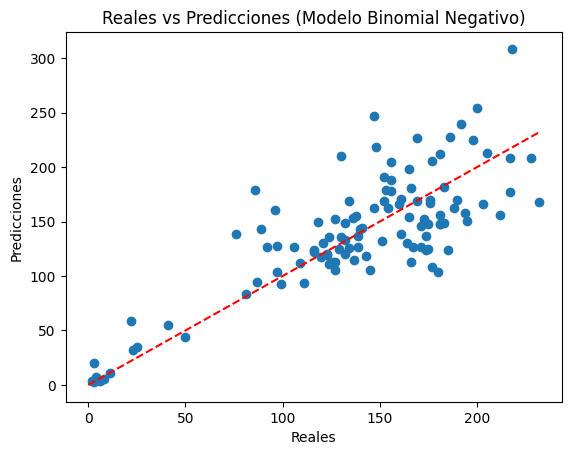

In [19]:
# Obtener las predicciones
df_agrupado["pred_fallas_nb"] = mod_nb.predict()

# Graficar predicciones vs reales
import matplotlib.pyplot as plt

plt.scatter(df_agrupado["fallas_mensual"], df_agrupado["pred_fallas_nb"])
plt.plot([0, df_agrupado["fallas_mensual"].max()], [0, df_agrupado["fallas_mensual"].max()], color='red', linestyle='--')
plt.title("Reales vs Predicciones (Modelo Binomial Negativo)")
plt.xlabel("Reales")
plt.ylabel("Predicciones")
plt.show()

### 9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investigación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

__R.__ Las diferencias son los coeficientes de los parametros y los $R^2$, hay diferencia en los modelos por su naturaleza, en la cual el modelo binomial negativo permite sobredispersion, el mas adecuado seria el binomial negativo, ya que hay presencia de un alpha de 0.15, y las variables robustas fueron el Parameter3_9am y Param2_9am_cos. Este analisis es valido con la agrupacion antes hecha, puede que de otra manera hubiesen variado los datos de otra manera.